In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/21h7_s_z_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,5.224356
1,0.000041,5.257265
2,8.586637,2.655489
3,9.573997,5.340838
4,10.024526,2.108278
...,...,...
206,111.088895,7.820048
207,111.588673,7.792327
208,112.568850,7.485427
209,113.045616,7.040644


<AxesSubplot:xlabel='relative_time'>

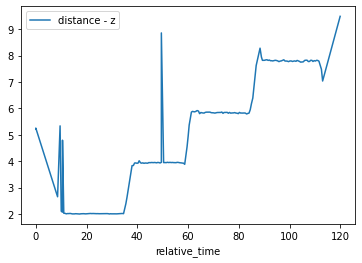

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .2)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

52

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

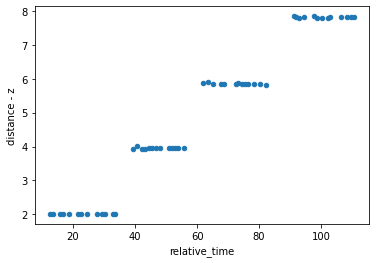

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
10,12.505683,2.018852,2
12,13.533989,2.024129,2
17,15.729962,2.013371,2
19,16.788374,2.010207,2
23,18.776854,2.014299,2
28,21.518665,2.022382,2
30,22.540047,2.020705,2
34,24.474675,2.016437,2
41,27.662508,2.019883,2
45,29.406790,2.011761,2


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
10,12.505683,2.018852,2,-0.018852
12,13.533989,2.024129,2,-0.024129
62,39.388113,3.936047,4,0.063953
65,40.738849,4.019158,4,-0.019158
108,61.787400,5.889651,6,0.110349
112,63.592329,5.921230,6,0.078770
166,91.114814,7.845517,8,0.154483
168,92.040180,7.834901,8,0.165099


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,13.0,-0.016994,0.004871,-0.024129,-0.020705,-0.016437,-0.013371,-0.009825
4,13.0,0.044043,0.020893,-0.019158,0.041415,0.045693,0.049664,0.065660
6,13.0,0.140650,0.023220,0.078770,0.138046,0.149318,0.151396,0.170395
8,13.0,0.178937,0.015730,0.154483,0.171295,0.175511,0.190062,0.202324


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

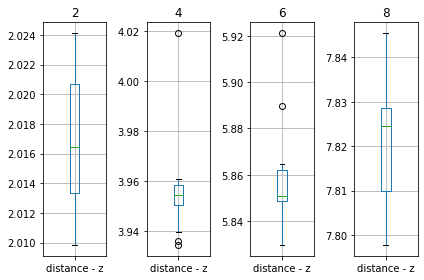

In [16]:
box_plotter(target)

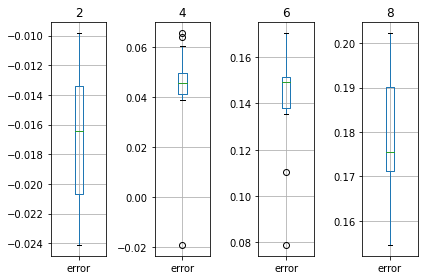

In [17]:
box_plotter('error')

In [18]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/translations/result/csv/21h7_1080.csv')